In [302]:
# Data reading 
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

# Data visualisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns

# NLP 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import collections

In [25]:
!pip install pipreqsnb
!pipreqsnb
!python3 -m spacy download en_core_web_sm

Exception occurred while working on file /Users/julkakubisa/gilmore_girls_network/script_scrape.ipynb, cell 4/5
Traceback (most recent call last):
  File "/opt/anaconda3/bin/pipreqsnb", line 8, in <module>
    sys.exit(main())
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 130, in main
    raise e
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "/opt/anaconda3/lib/python3.9/site-packages/pipreqsnb/pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "/opt/anaconda3/lib/python3.9/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 2
    for item_link in item_links[]:
                                ^
SyntaxError: invalid syntax


In [333]:
# Load datasets 
characters = pd.read_csv("data/characters_list.csv", sep='\t') # List of characters
script = pd.read_csv("data/Gilmore_Girls_Lines.csv", sep=',')

In [334]:
script

,Character,Line,Season
0,Lorelai,"Please, Luke. Please, please, please.",1
1,Luke,How many cups have you had this morning?,1
2,Lorelai,None.,1
3,Luke,Plus...,1
4,Lorelai,"Five, but yours is better.",1
...,...,...,...
115200,Rory,Well It wasn't very flattering.,7
115201,Lorelai,Well how will people know you're the world's g...,7
115202,Rory,I don't know.,7
115203,Lorelai,I guess they'll just have to read your stuff.,7


In [335]:
# Count lines by character
char_lines = script.groupby(['Character'], as_index=False)['Line'].count().sort_values(['Line'], ascending=False)

In [336]:
# Percent of lines said by character
char_lines['Percent'] = char_lines['Line']/char_lines['Line'].sum()

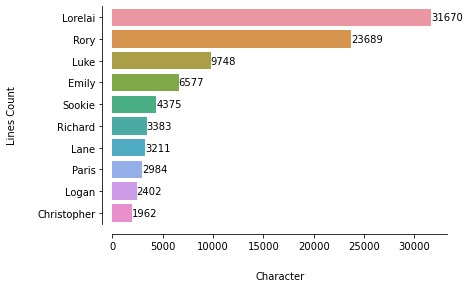

In [348]:
# Barplot of said lines 

# Set style 
sns.set_palette('Set2')

# Plot 
fig = sns.barplot(data=char_lines[:10], x="Line", y="Character")

# Customize
plt.ylabel("Lines Count", labelpad=20)
plt.xlabel("Character",labelpad=20)
sns.despine(offset=10)

for i in fig.containers:
    fig.bar_label(i,)

In [338]:
# Number of character per season
seasons_char= script.groupby(['Season'], as_index=False)['Character'].nunique().sort_values('Character', ascending=False)

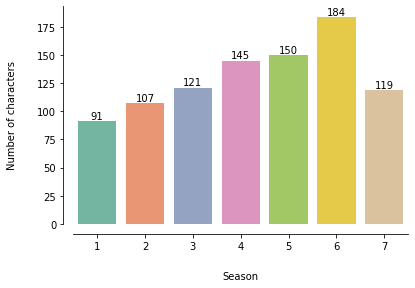

In [347]:
# Barplot of seasons characters distribution 
fig2 = sns.barplot(data=seasons_char, x="Season", y="Character")
plt.ylabel("Number of characters", labelpad=20)
plt.xlabel("Season",labelpad=20)
sns.despine(offset=10)
for i in fig2.containers:
    fig2.bar_label(i,)

In [340]:
# Number of lines per season
count_lines = script.groupby(['Season'], as_index=False)['Line'].count().sort_values('Line', ascending=True)

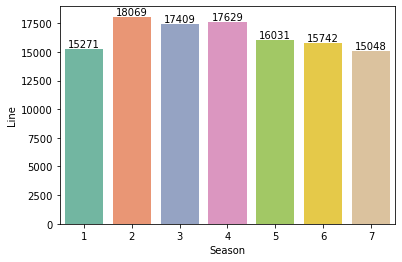

In [349]:
fig3 = sns.barplot(data=count_lines, x="Season", y="Line")
for i in fig3.containers:
    fig3.bar_label(i,)

In [342]:
# Import stopwords 
stop_words = stopwords.words('english')
stop_words.extend(["uh","oh","okay","im","dont", "know", "yeah", "thats", "youre", "well", "what", "ok", "isnt", "dont",
                  "yes", "no", "theres", "cant", "didnt", "whats"])

In [343]:
# Characters lines 
lorelai = script[script['Character'] == "Lorelai"].reset_index(drop=True)
lorelai = lorelai['Line']
rory = script[script['Character'] == "Rory"].reset_index(drop=True)
rory = rory['Line']
luke = script[script['Character'] == "Luke"].reset_index(drop=True)
luke = luke['Line']


In [373]:
# Tokenize and clean data 
def clean_data(data):
    data = " ".join(data) # Join the text 
    data = re.sub(r'[^\w\s]', '', data) # Delete unwanted characters 
    tokens = data.split() 
    tokens = [word.lower() for word in tokens] # Lower all the letters 
    tokens = [word for word in tokens if not word in stop_words] # Ignore stopwords
    text = " ".join(tokens) # Create one joined sentence  
    return text

In [381]:
# Generate wordcloud 
def generate_wordcloud(text):
    word_cloud= WordCloud(width=1920,height=1080, background_color="white", colormap='tab20b', collocations=False).generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(word_cloud)

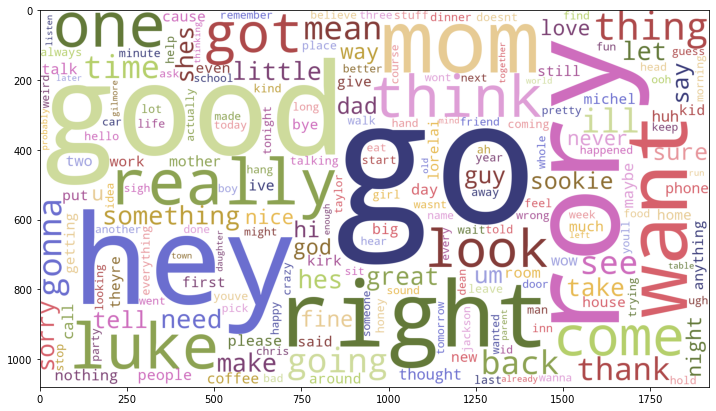

In [382]:
lorelai_text = clean_data(lorelai)
generate_wordcloud(lorelai_text)

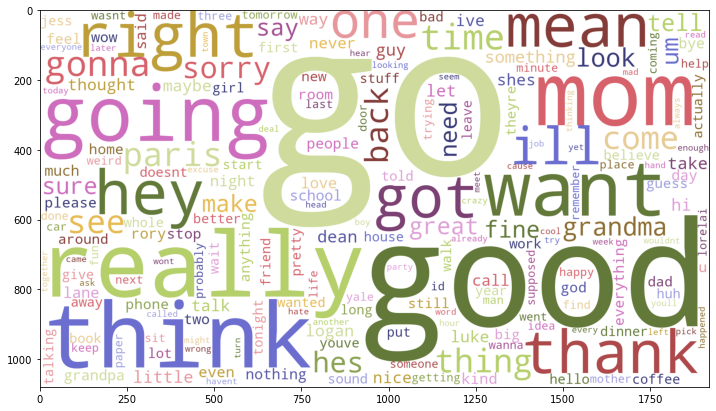

In [384]:
rory_text = clean_data(rory)
generate_wordcloud(rory_text)

In [400]:
# Network 
relationships = []

for i in range(script.index[-1]): # up to the penultimate
    end_i = min(i+5, script.index[-1])
    print(end_i)
    # char_list = sum((script.loc[i: end_i].Character), [])

    
#     # Remove duplicated characters that are next to each other
#     char_unique = [char_list[i] for i in range(len(char_list)) 
#                    if (i==0) or char_list[i] != char_list[i-1]]
    
#     if len(char_unique) > 1:
#         for idx, a in enumerate(char_unique[:-1]):
#             b = char_unique[idx + 1]
#             relationships.append({"source": a, "target": b})

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
